import sys, importlib
importlib.reload(sys.modules['classic_CV_predict'])

In [1]:
import sys
sys.path.insert(0, "..")


from sf_runoff import daily_climatology, spatial_avg_daily_input, spatial_stats_daily_input, compute_anomalies, create_it_matrix
from nested_CV import SVR_nested_CV_gridsearch, SVR_PCA_nested_CV_gridsearch
from test import evaluate_prediction, plot_prediction, plot_anomalies
from test import nested_CV_PCA_SVR_predict, nested_CV_SVR_predict
from classic_CV_predict import classic_CV_PCA_SVR_predict, classic_CV_SVR_predict


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import os
import pdb
import seaborn as sns

## A) ALL_VARS, T_UNIT = 30

In [2]:
path=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\daily_input\old\\'

daily_input = pd.read_csv(path+'Etsch-Branzoll_85550PG_8555QQ0010A_19761231000000_20210721000000.csv', index_col=0, parse_dates=True)

daily_input_stat = spatial_stats_daily_input(daily_input)
#daily_input_stat=daily_input_stat[daily_input_stat.index.dayofyear%2==1]

t_unit=30


#define the possible parameters value (where Gridsearch is applied)

C_range=np.logspace(-1.5, 1.5, 10)
epsilon_range=np.logspace(-5, -2, 5)

#do not enlarge t_range for now
t_range=[12]
t_length=t_range[0]
n_splits=5
test_size=365

Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits

C3=0.31622776601683794
eps3=5.623413251903491e-05


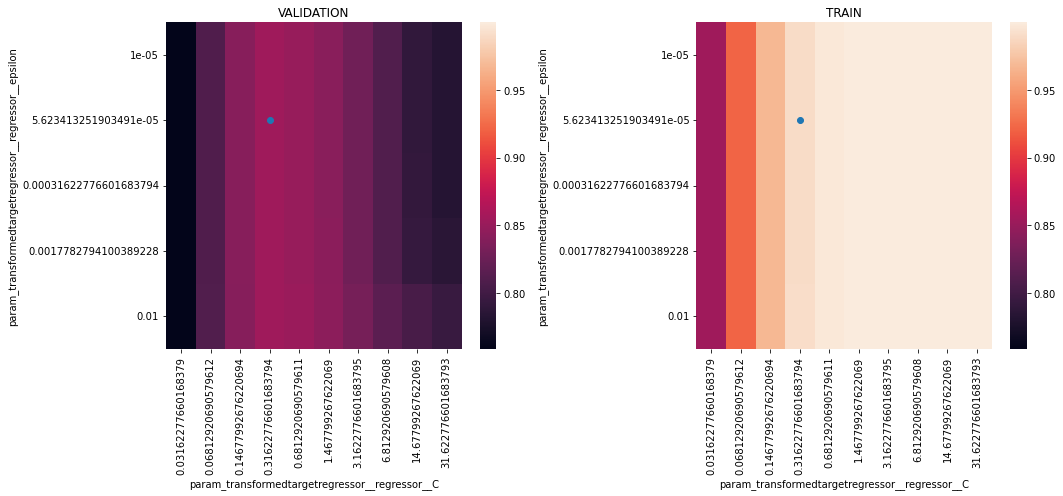

In [3]:
C, eps = SVR_nested_CV_gridsearch(daily_input_stat, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C3={C}')
print(f'eps3={eps}') 

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [4]:
radius_for_ensemble = 1
predictions = nested_CV_SVR_predict(daily_input_stat, C, eps, t_length,t_unit, n_splits, test_size, radius_for_ensemble)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

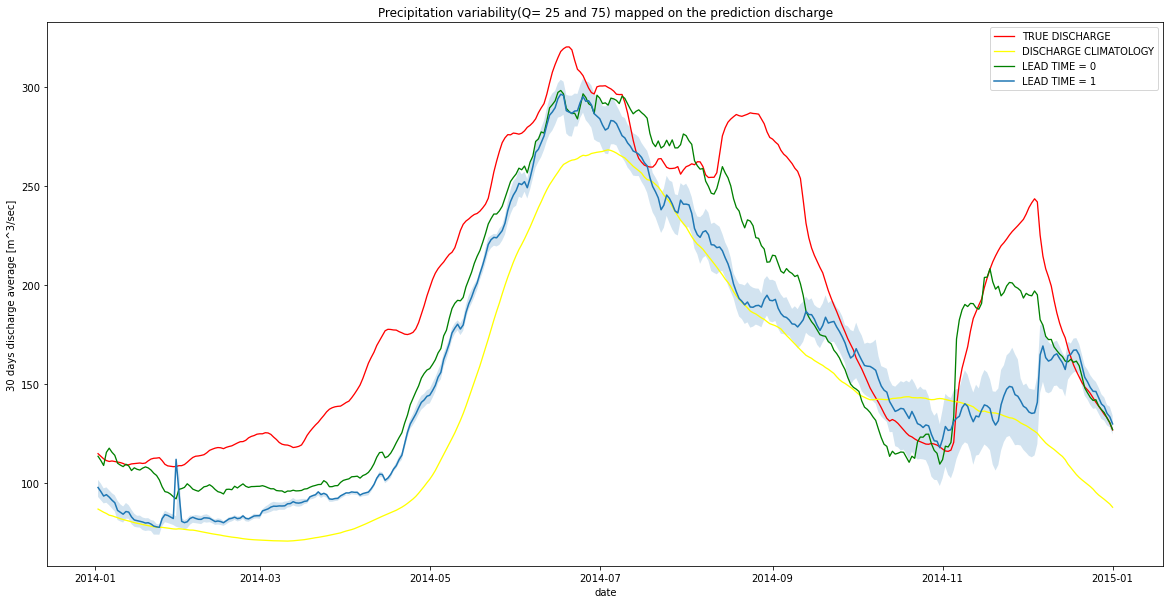

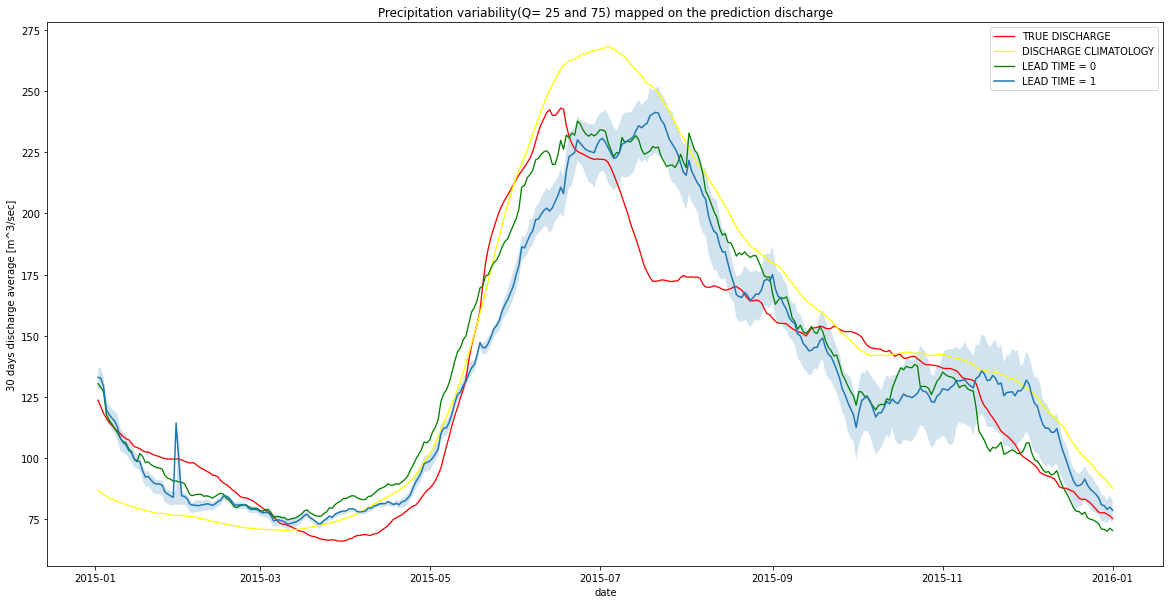

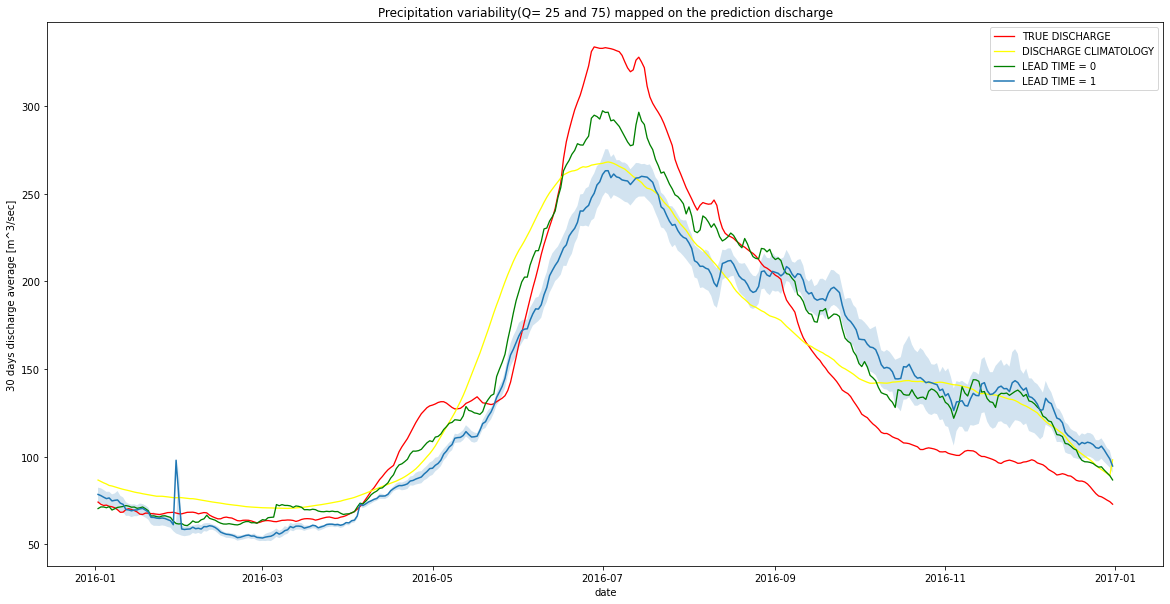

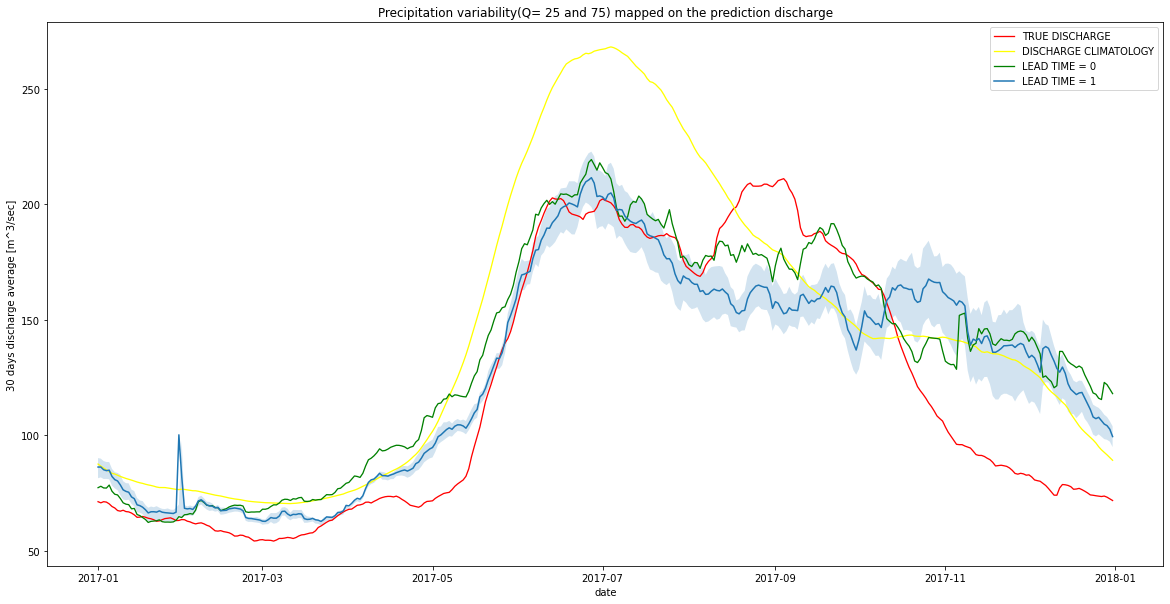

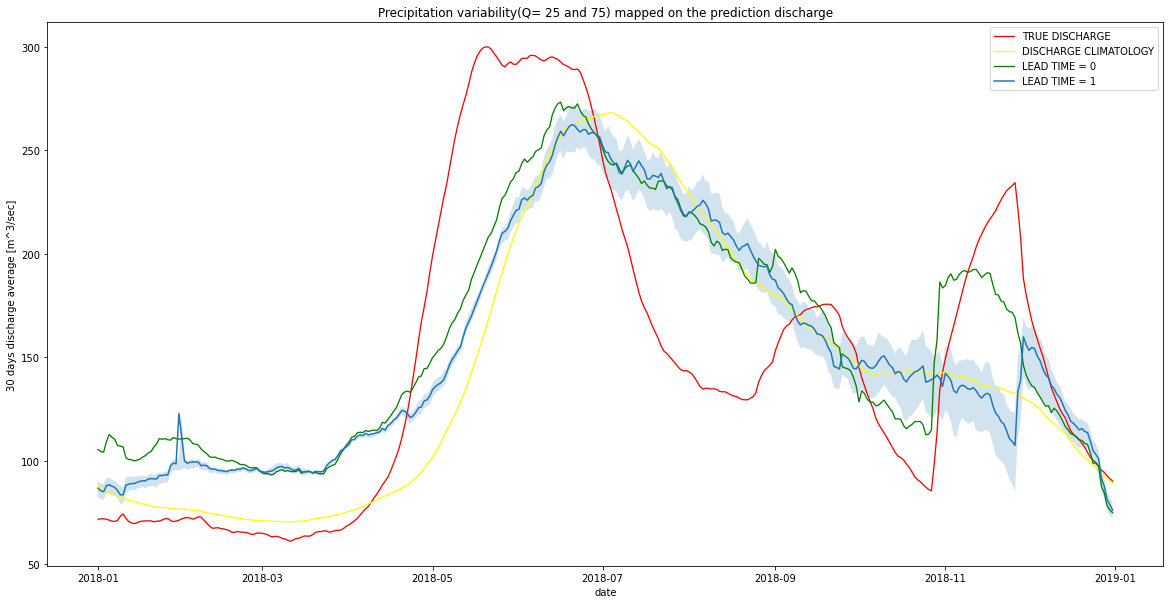

In [5]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions)

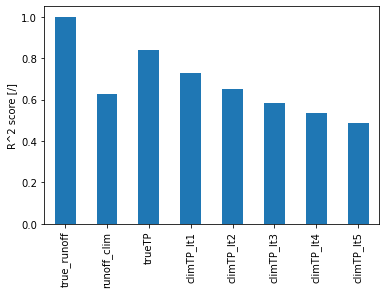

In [6]:
r2_A= evaluate_prediction(predictions)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [7]:
predictions_for_clim = classic_CV_SVR_predict(daily_input_stat, C, eps, t_length,t_unit, n_splits)

In [8]:
climatologies =predictions_for_clim.groupby(by=predictions_for_clim.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies['doty']=climatologies.index


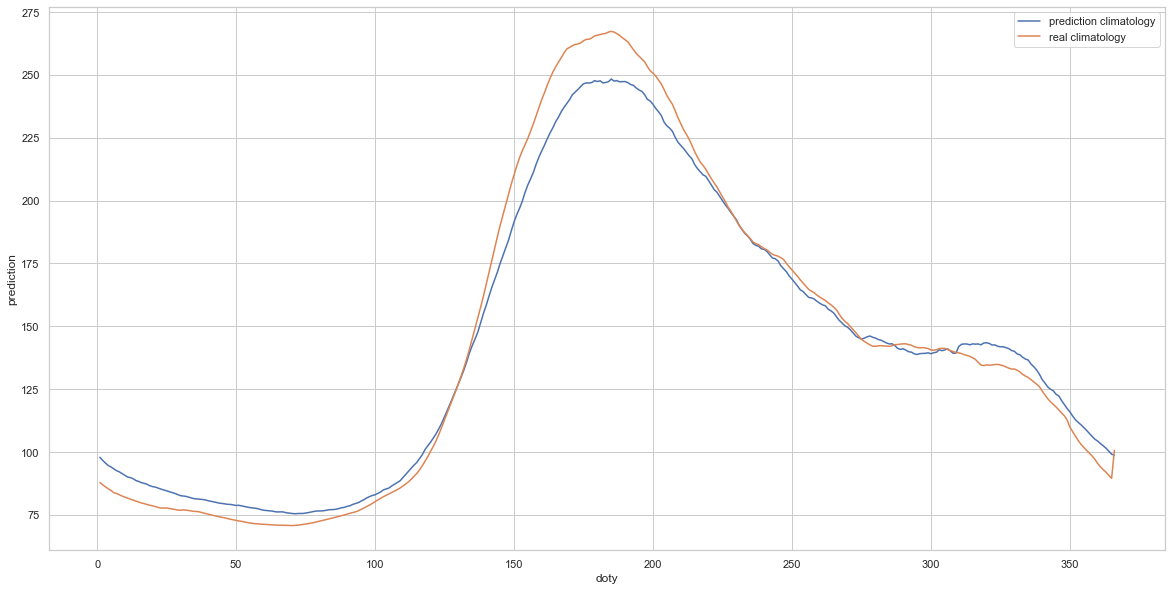

In [9]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

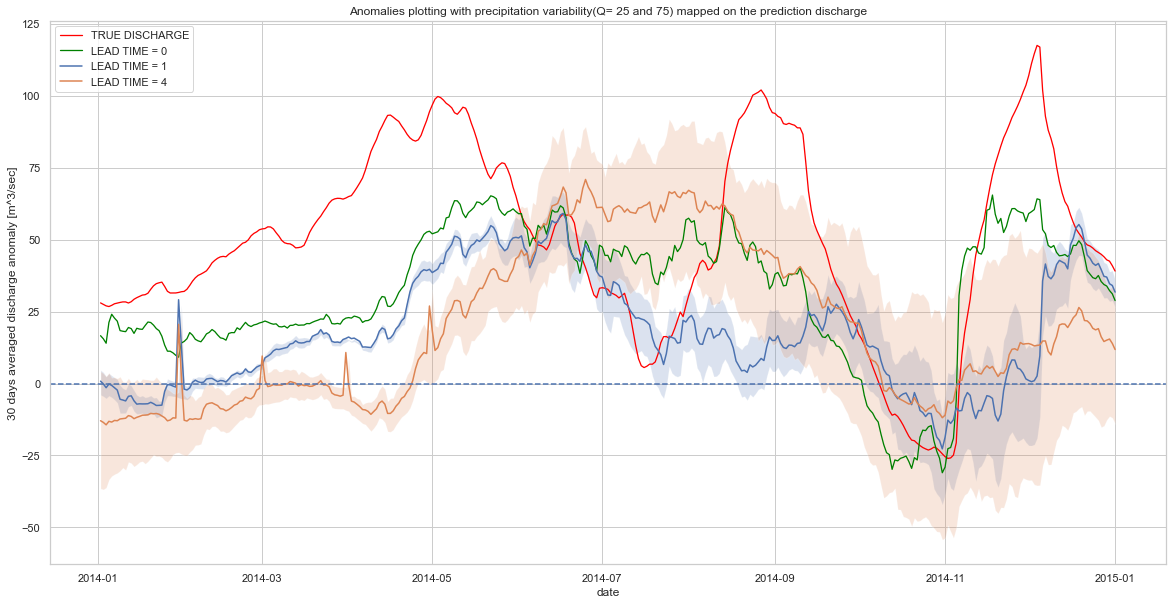

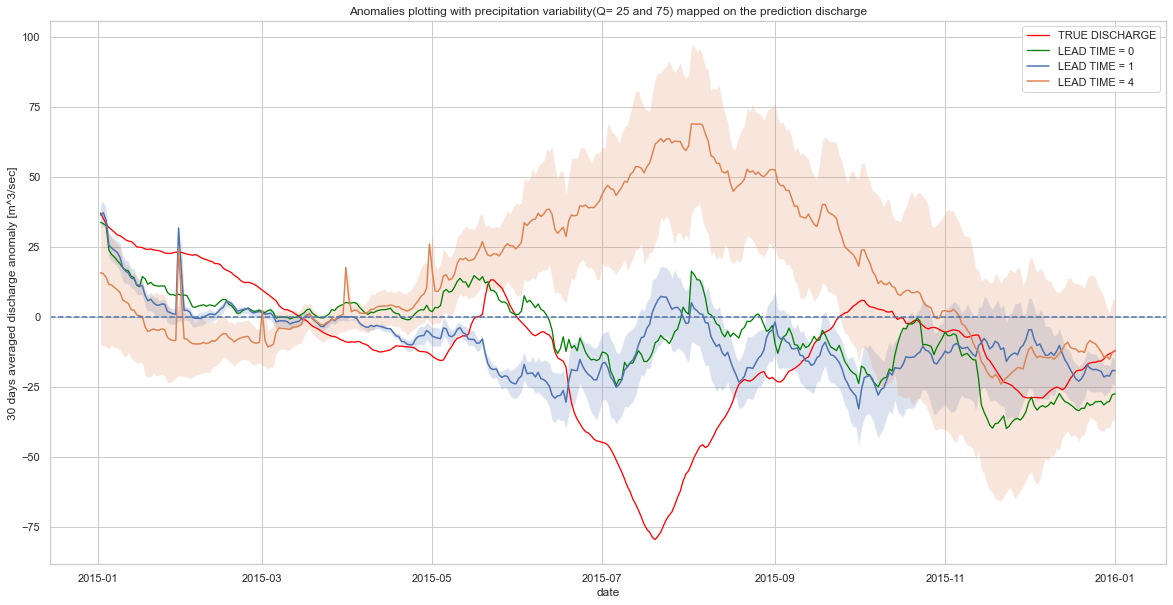

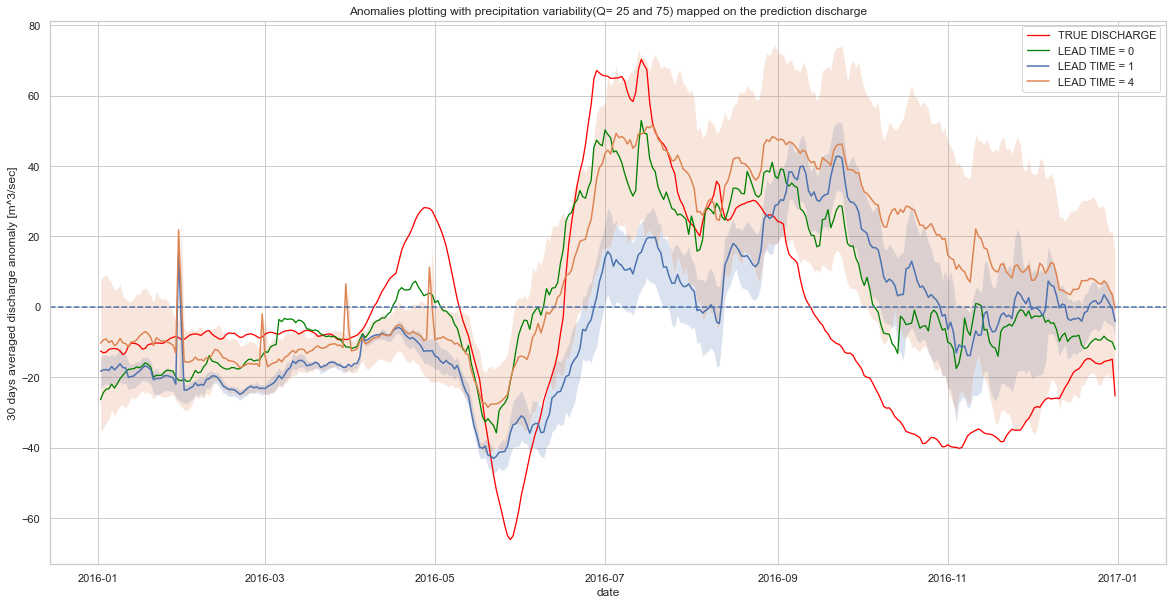

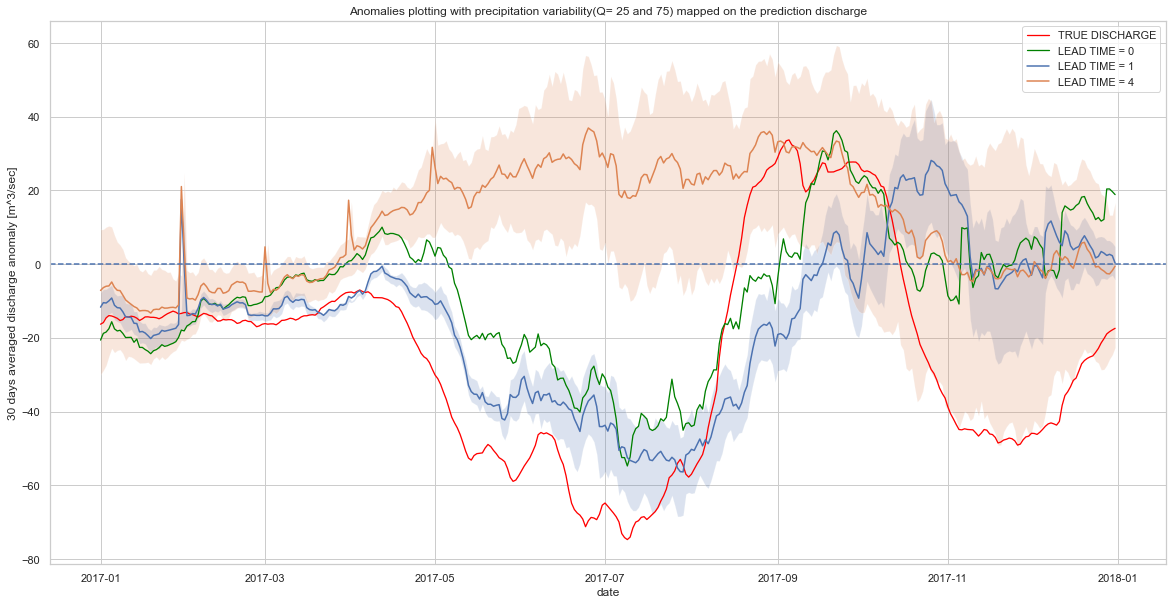

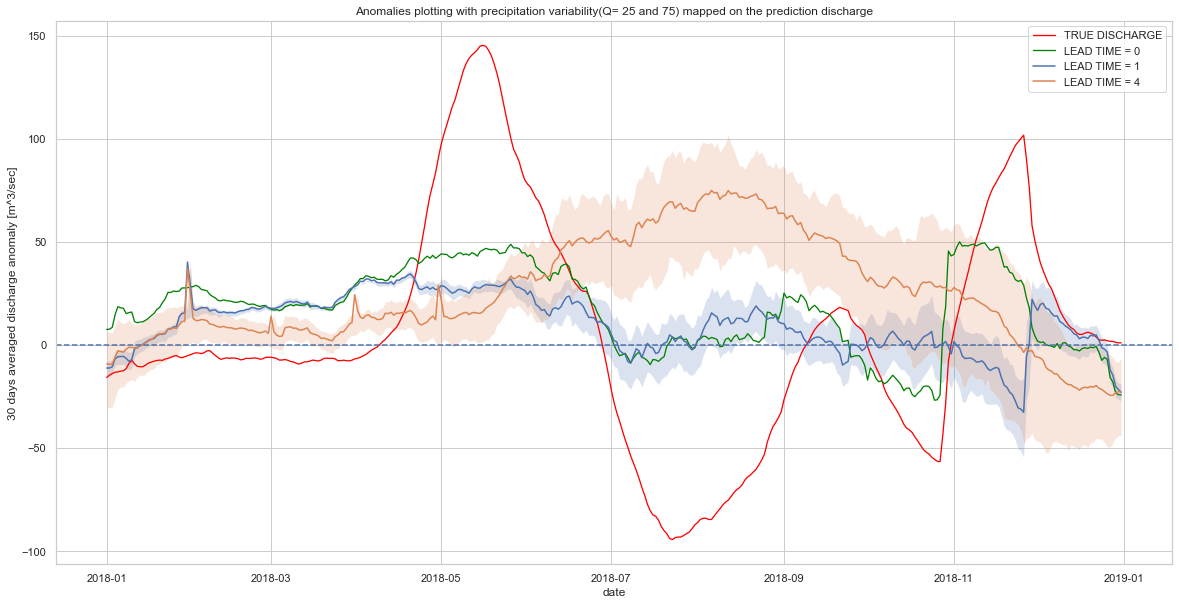

In [10]:
a=compute_anomalies(climatologies, predictions)
a['split']=predictions.split

plot_anomalies(a)

In [11]:
daily_input_stat.drop(columns=[c for c in daily_input_stat.columns if c[0]=='S'])

Q           T          T5         T25         T75  \
1979-01-01        NaN  263.233106  256.584235  261.240741  265.133502   
1979-01-02        NaN  253.105533  244.503615  249.973538  255.831392   
1979-01-03        NaN  254.002066  246.376589  250.759038  256.725507   
1979-01-04        NaN  252.791783  245.285024  250.420247  255.174581   
1979-01-05        NaN  253.703867  246.532429  251.616495  255.872582   
...               ...         ...         ...         ...         ...   
2018-12-27  76.330903  267.262865  261.944776  265.111961  269.705360   
2018-12-28  83.782569  269.963519  265.724448  268.554004  271.408550   
2018-12-29  77.280208  268.116355  262.759418  266.330239  269.870776   
2018-12-30  76.731875  268.759053  263.233087  266.914712  270.282620   
2018-12-31  74.361111  270.963640  266.426076  269.107575  272.668388   

                   T95         E        E5       E25       E75       E95  \
1979-01-01  269.789197 -0.028059 -0.277070 -0.112369  0.063002  0.168055   
1979-01-02  260.858369  0.088985 -0.098545 -0.008884  0.150078  0.434573   
1979-01-03  261.040903  0.011213 -0.142579 -0.061551  0.086000  0.192036   
1979-01-04  258.954931  0.029131 -0.105141 -0.042972  0.087678  0.220514   
1979-01-05  258.525746  0.056131 -0.140100 -0.026397  0.129912  0.313451   
...                ...       ...       ...       ...       ...       ...   
2018-12-27  273.399211  0.146285 -0.228168 -0.046170  0.332894  0.613065   
2018-12-28  275.032568  0.016211 -0.288084 -0.128170  0.161029  0.421438   
2018-12-29  274.215474 -0.046698 -0.312401 -0.188381  0.084250  0.309984   
2018-12-30  274.824046  0.208927 -0.115204  0.063237  0.354525  0.539349   
2018-12-31  276.498897  0.196520 -0.049985  0.075699  0.302784  0.495614   

                       P        P5       P25       P75       P95  
1979-01-01           NaN       NaN       NaN       NaN       NaN  
1979-01-02  1.085464e+00  0.111548  0.558067  1.435430  2.615847  
1979-01-03  6.487961e-01  0.056268  0.181848  0.825405  2.258213  
1979-01-04  1.539004e-01  0.005108  0.020184  0.155851  0.811798  
1979-01-05  2.899194e-03  0.000000  0.000000  0.001570  0.008199  
...                  ...       ...       ...       ...       ...  
2018-12-27  1.071818e-08  0.000000  0.000000  0.000000  0.000000  
2018-12-28  0.000000e+00  0.000000  0.000000  0.000000  0.000000  
2018-12-29  3.275556e-04  0.000022  0.000102  0.000407  0.001015  
2018-12-30  3.024242e-01  0.018301  0.036984  0.362665  1.297155  
2018-12-31  2.927166e+00  0.242020  0.838584  3.860525  9.702262  

[14610 rows x 16 columns]

## B) NO_SNOW, T_UNIT = 30

In [12]:
daily_input_stat2 = daily_input_stat.drop(columns=[c for c in daily_input_stat.columns if c[0]=='S'])


In [13]:
#define the possible parameters value (where Gridsearch is applied)

C_range=np.logspace(-1.5, 1.5, 10)
epsilon_range=np.logspace(-5, -2, 5)

#n_range = [17, 50, 200]
components_range = [5*4*36]
#do not enlarge t_range for now
t_range=[36]
t_length=t_range[0]
n_splits=5
test_size=365

Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits

C2=0.14677992676220694
eps2=0.01


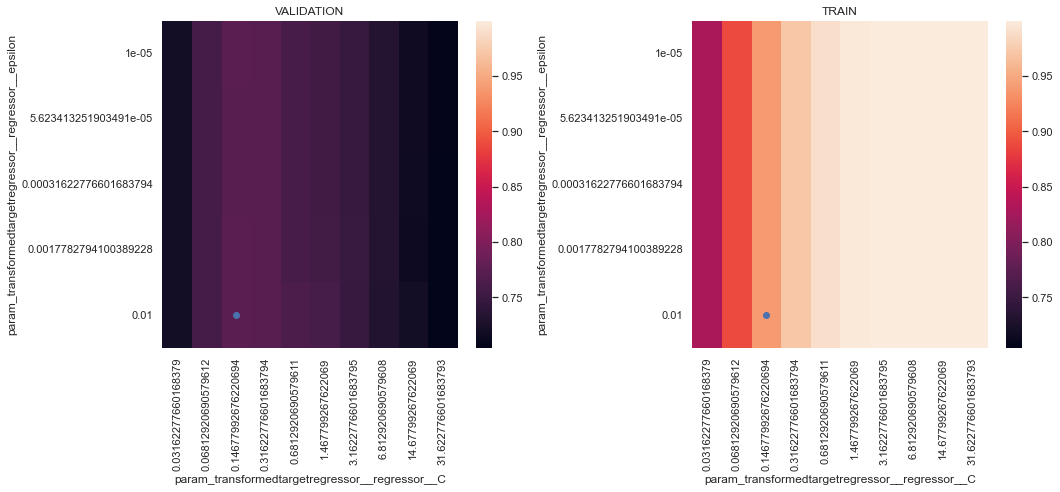

In [14]:
C2, eps2 = SVR_nested_CV_gridsearch(daily_input_stat2, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C2={C2}')
print(f'eps2={eps2}')

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [15]:
radius_for_ensemble = 1
predictions2 = nested_CV_SVR_predict(daily_input_stat2, C2, eps2, t_length, t_unit, n_splits, test_size, radius_for_ensemble)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

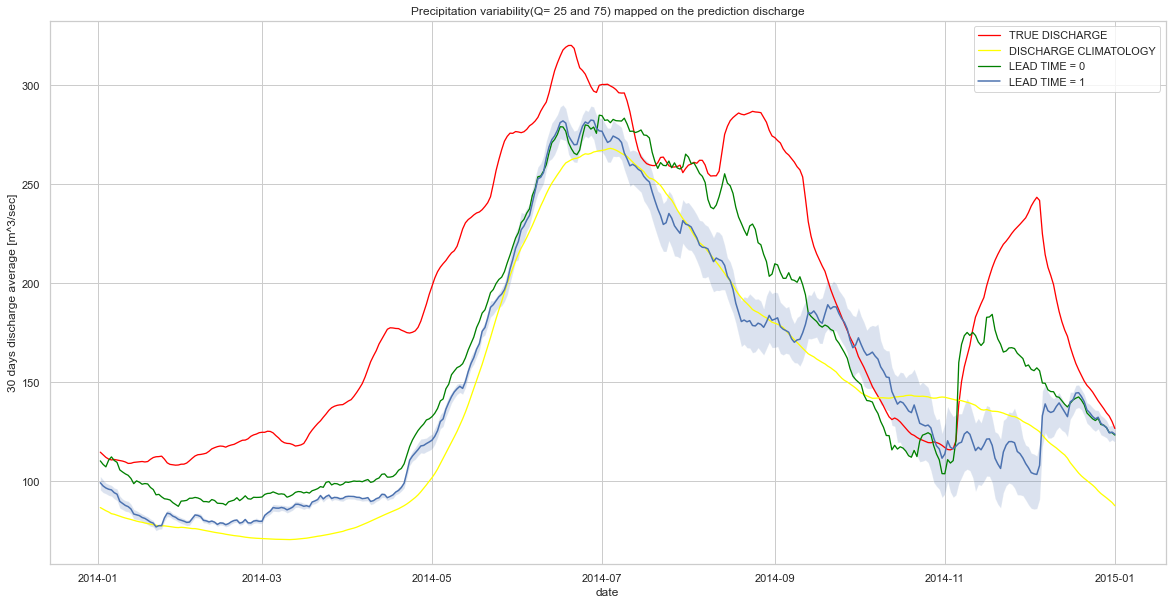

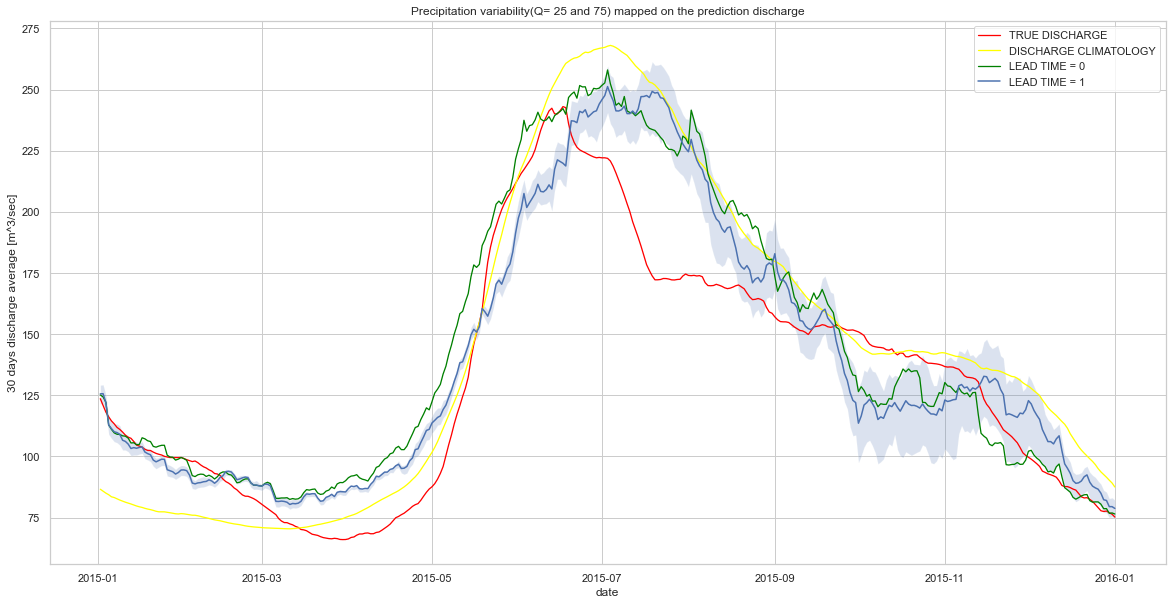

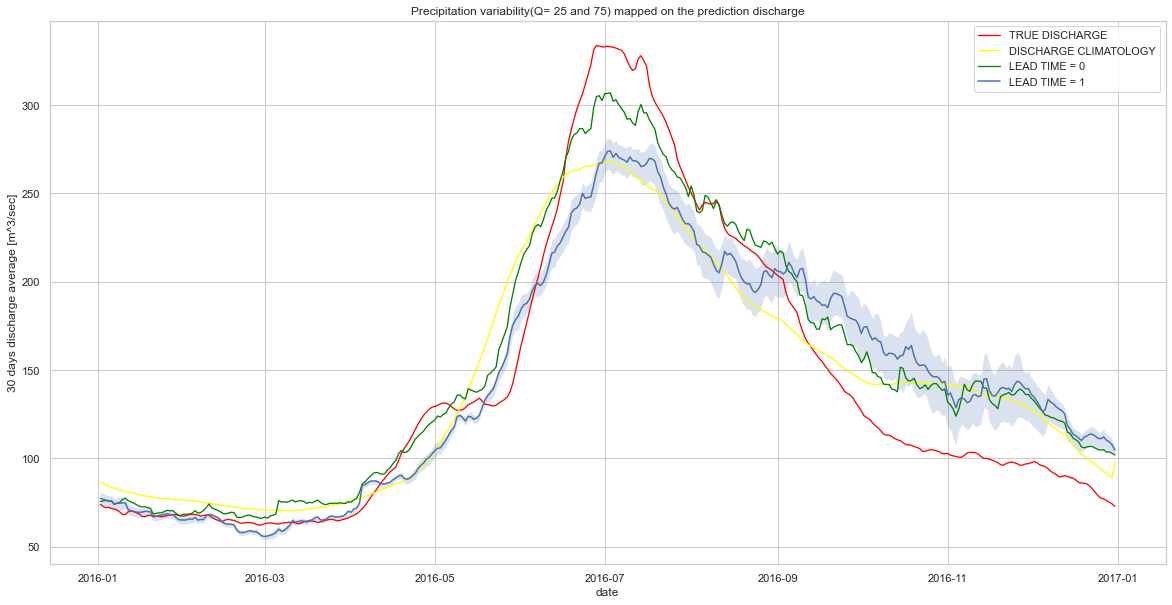

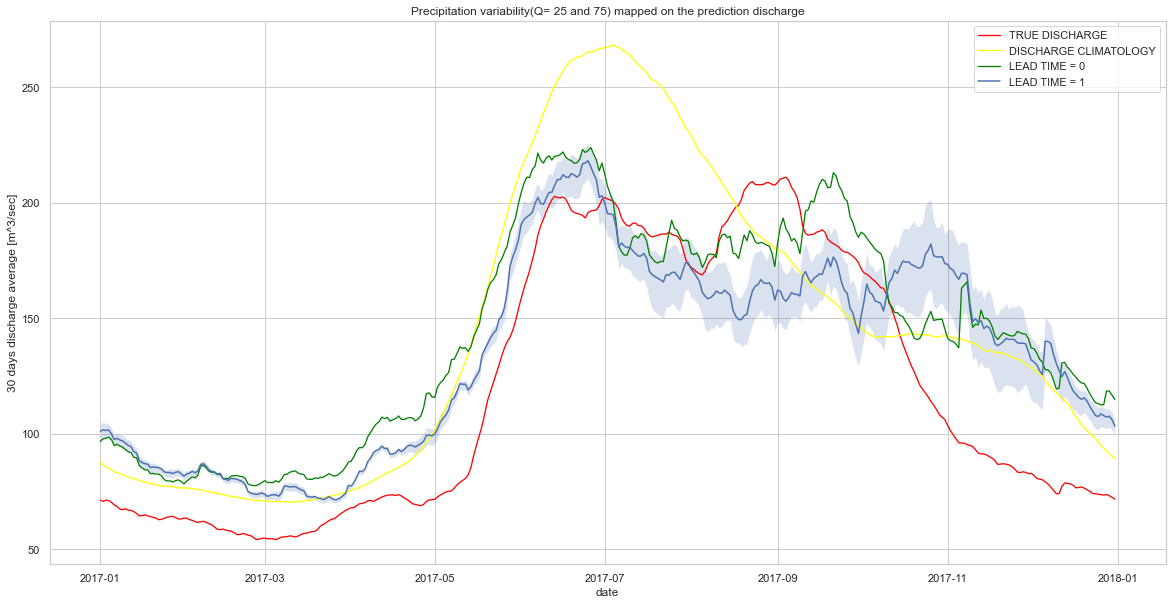

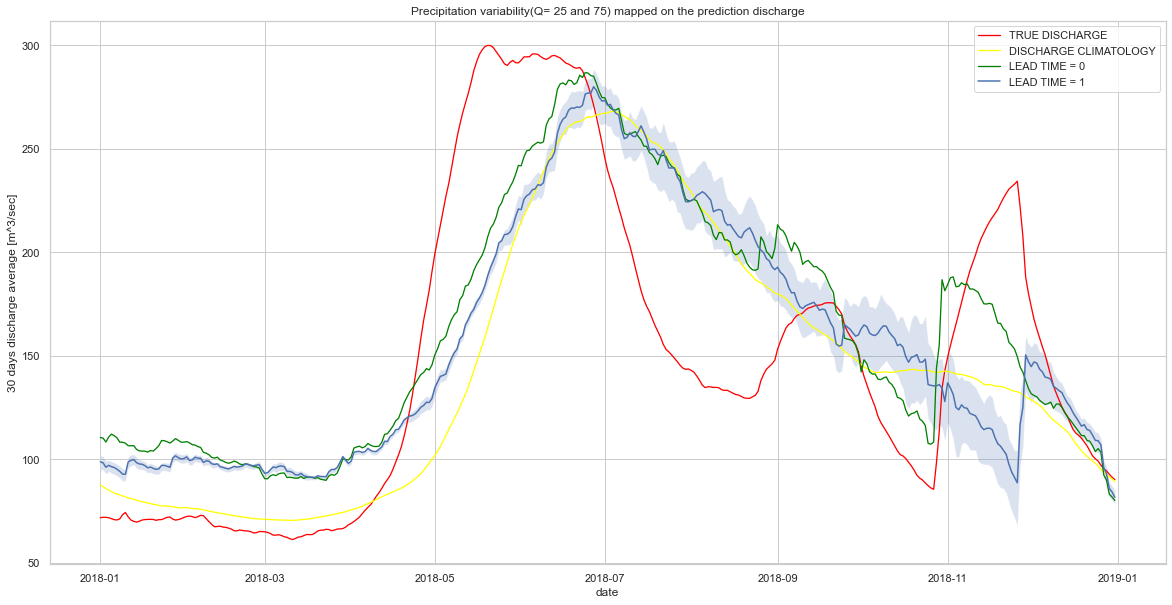

In [16]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions2)

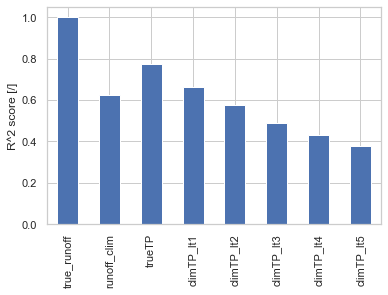

In [17]:
r2_B= evaluate_prediction(predictions2)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [18]:
predictions_for_clim2 = classic_CV_SVR_predict(daily_input_stat2, C2, eps2, t_length, t_unit, n_splits)

In [19]:
climatologies2 =predictions_for_clim2.groupby(by=predictions_for_clim2.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies2['doty']=climatologies2.index


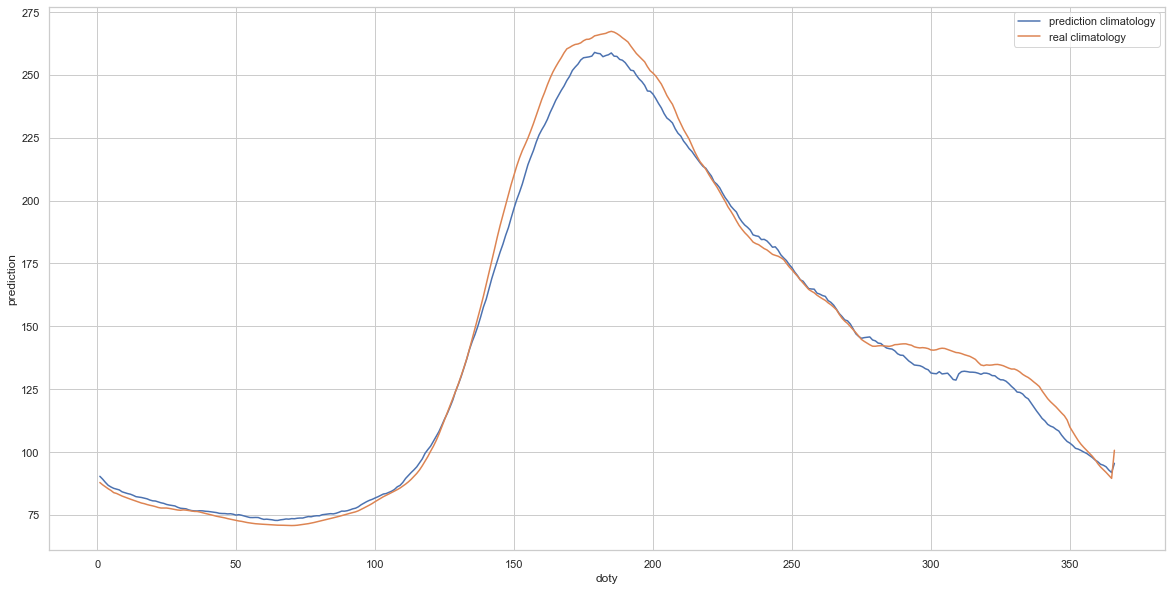

In [20]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies2,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies2,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

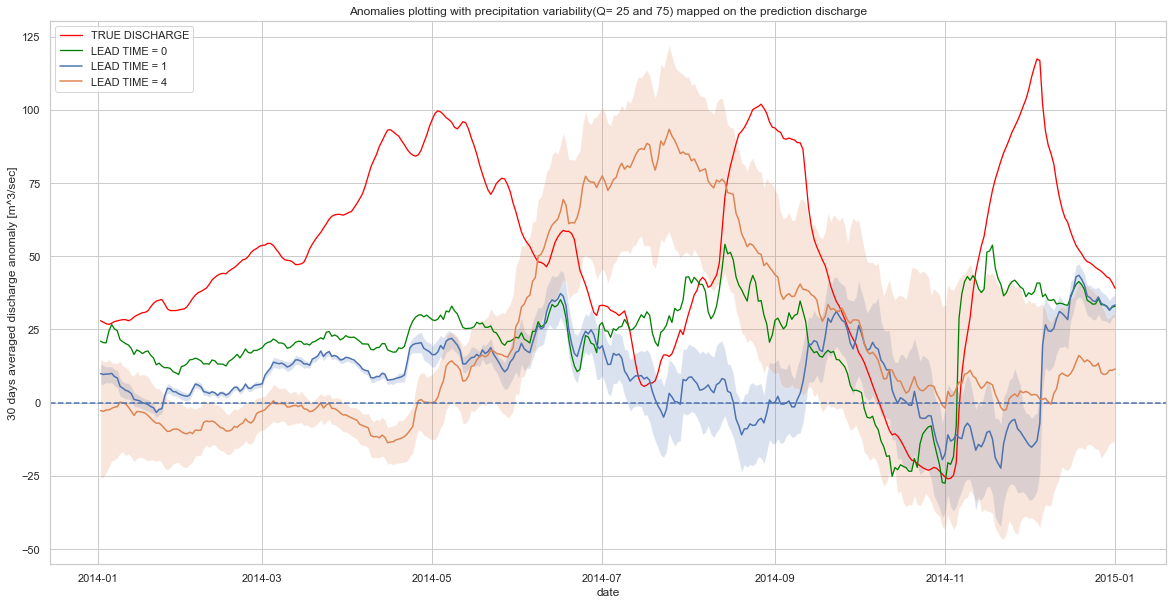

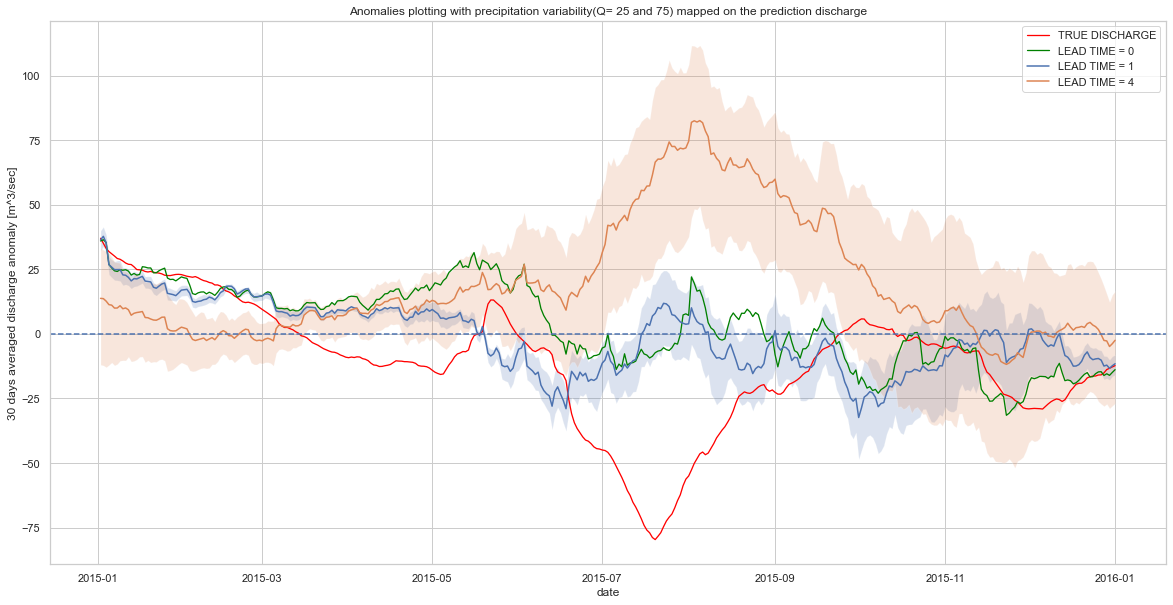

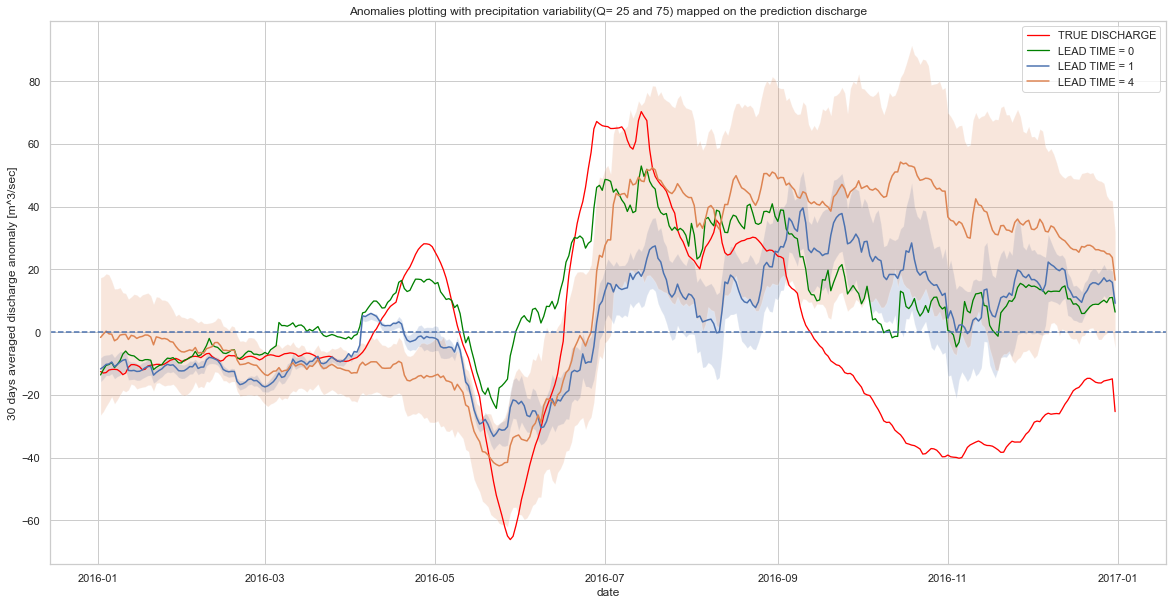

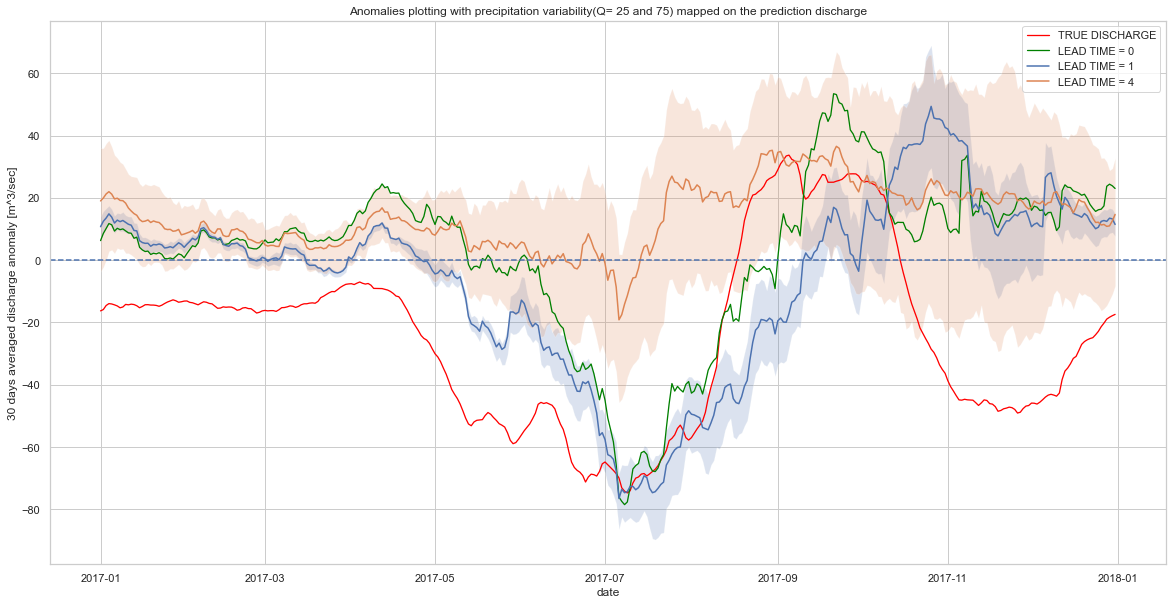

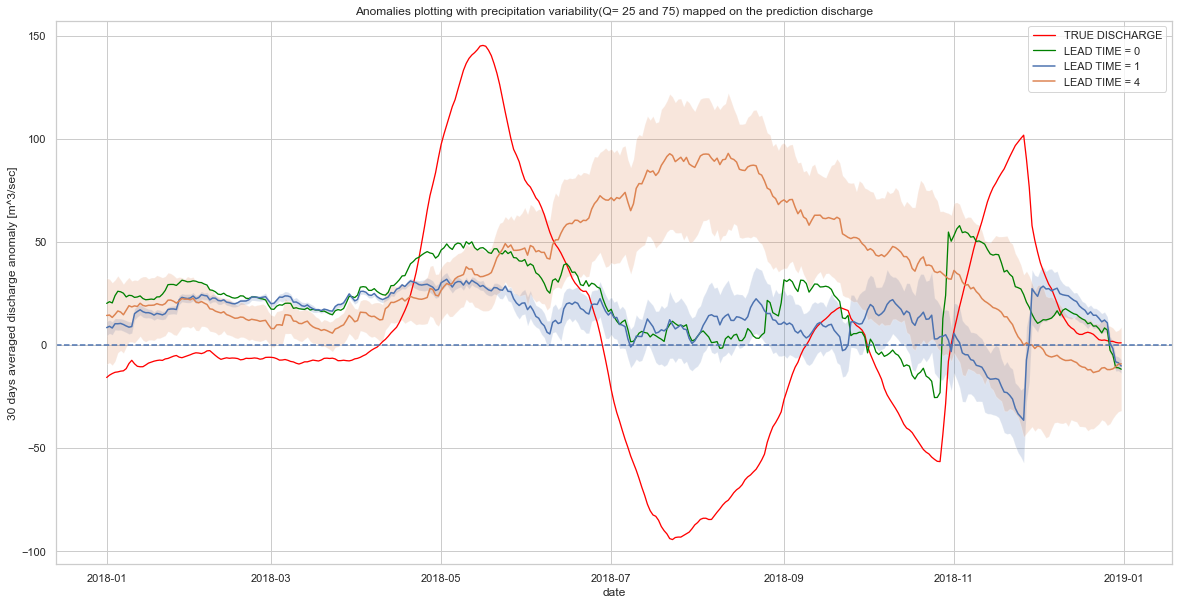

In [21]:
a2=compute_anomalies(climatologies2, predictions2)
a2['split']=predictions2.split

plot_anomalies(a2)

## C) NO_EVAP, T_UNIT = 30

In [22]:
daily_input_stat3 = daily_input_stat.drop(columns=[c for c in daily_input_stat.columns if c[0]=='E'])

t_unit=30

Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits

C3=0.31622776601683794
eps3=0.0017782794100389228


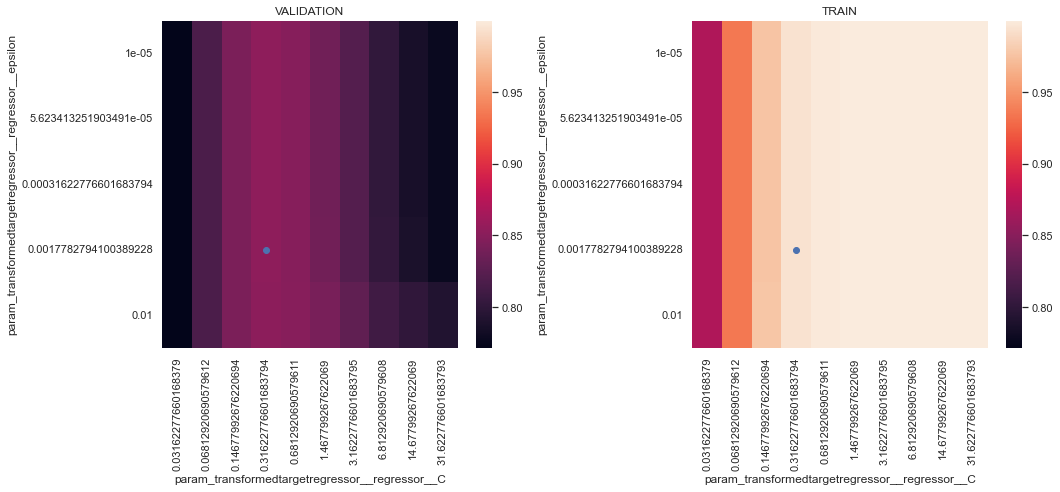

In [23]:
C3, eps3 = SVR_nested_CV_gridsearch(daily_input_stat3, C_range, epsilon_range, t_range, t_unit, n_splits, test_size)
print(f'C3={C3}')
print(f'eps3={eps3}')

In [24]:
C3=0.17782794100
eps3=0.316227766016

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [25]:
radius_for_ensemble = 1
predictions3 = nested_CV_SVR_predict(daily_input_stat3, C3, eps3, t_length, t_unit, n_splits, test_size, radius_for_ensemble)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

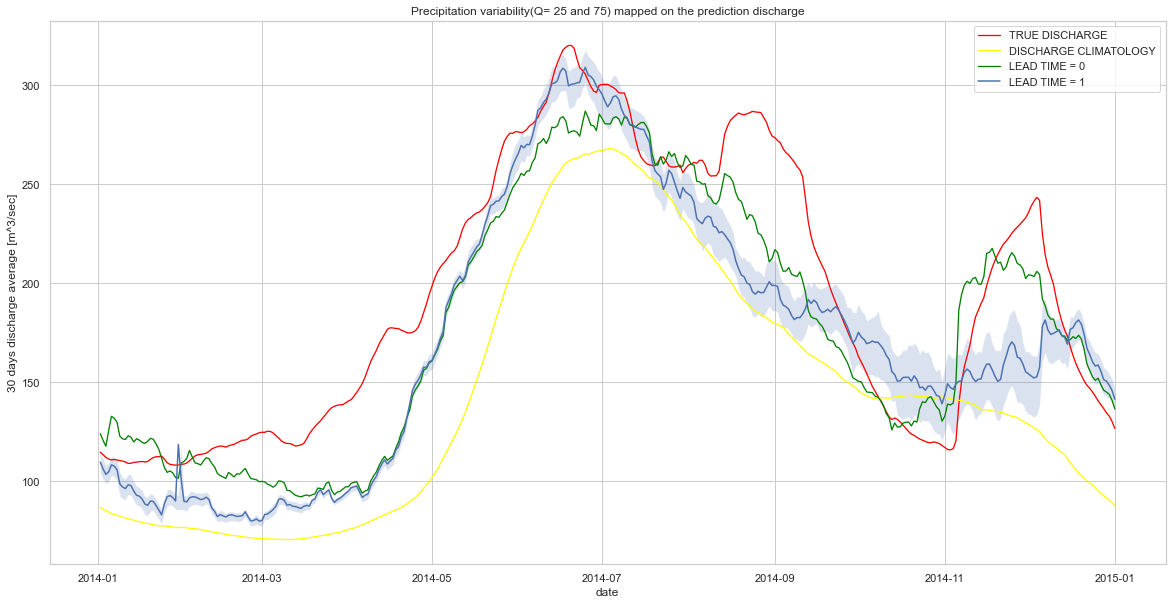

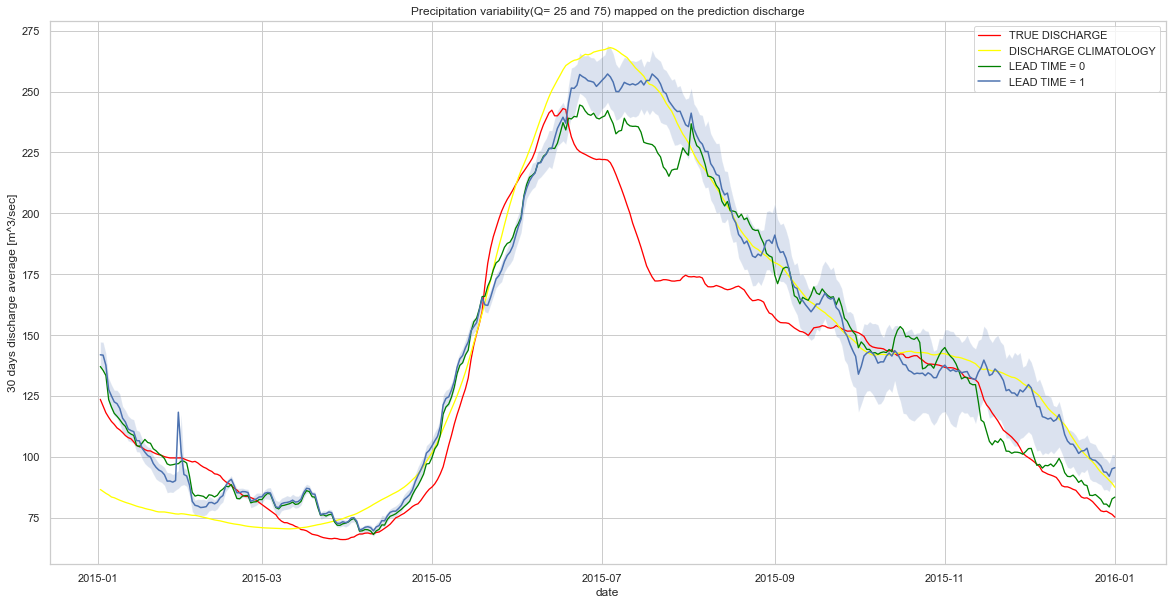

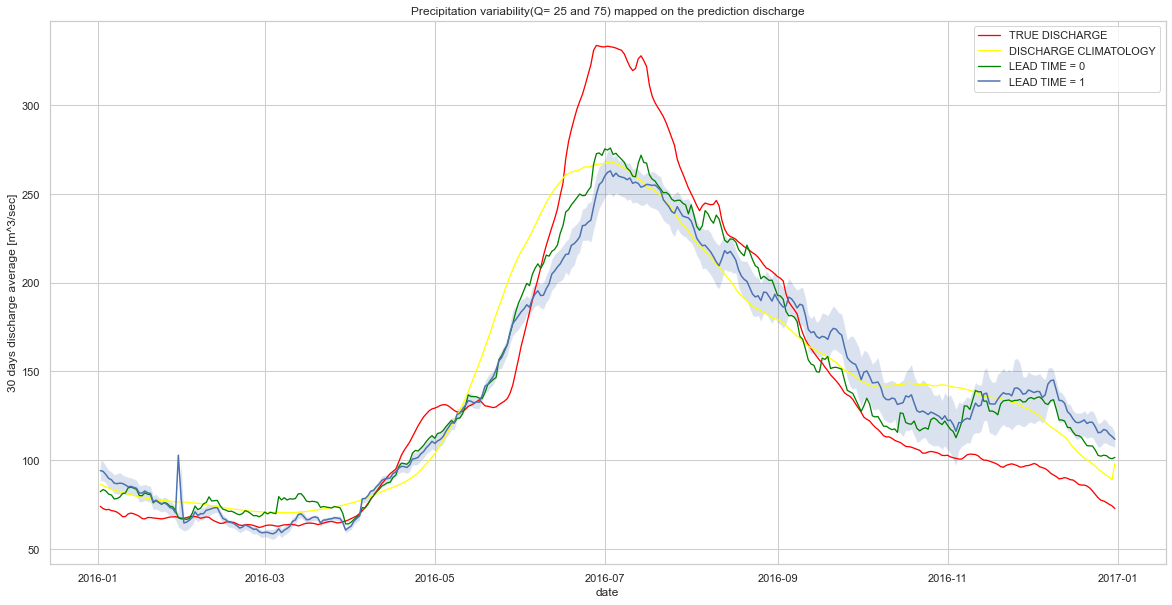

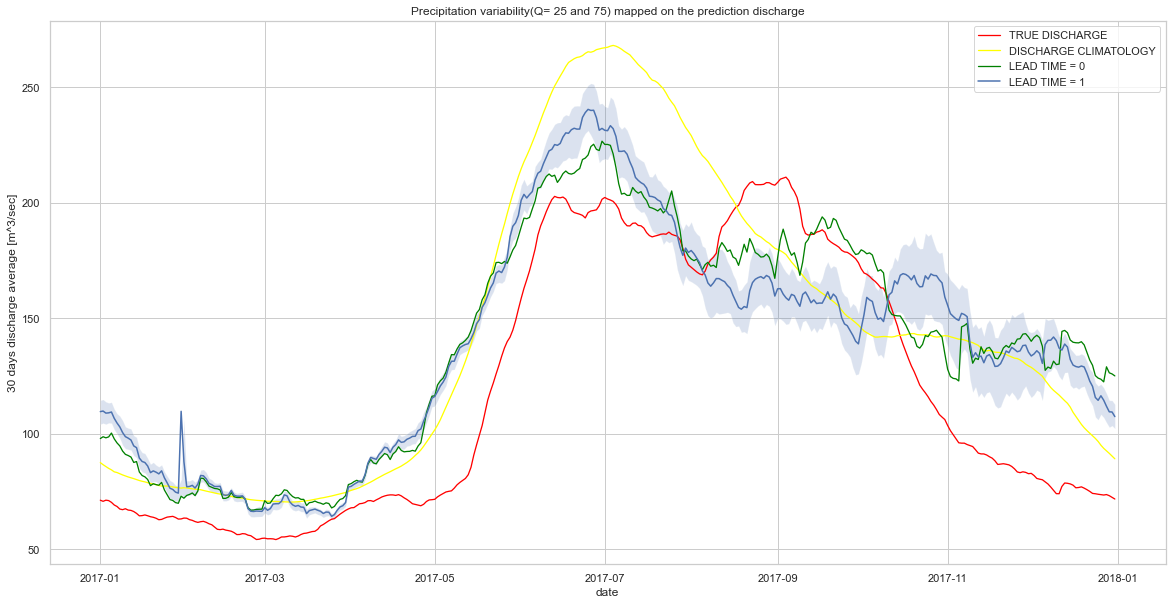

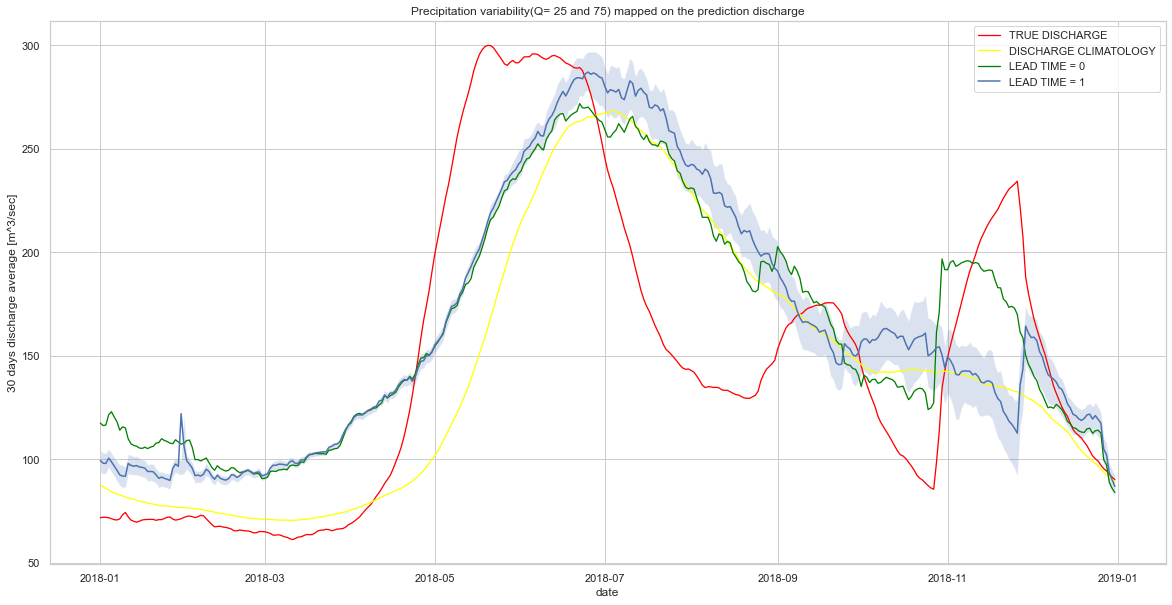

In [26]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions3)

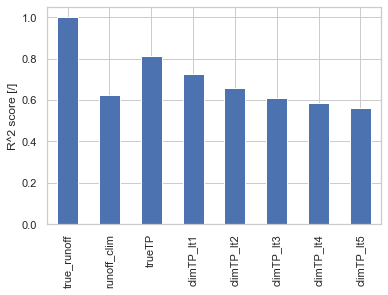

In [27]:
r2_C= evaluate_prediction(predictions3)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [28]:
predictions_for_clim3 = classic_CV_SVR_predict(daily_input_stat3, C3, eps3, t_length, t_unit, n_splits)

In [29]:
climatologies3 =predictions_for_clim3.groupby(by=predictions_for_clim3.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies3['doty']=climatologies3.index


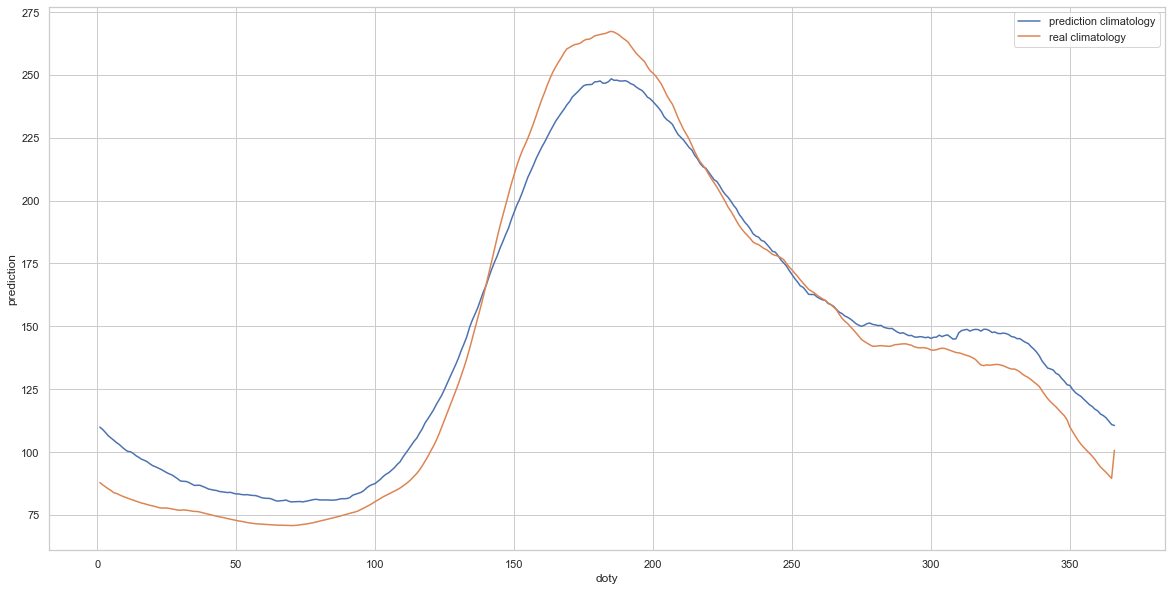

In [30]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies3,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies3,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

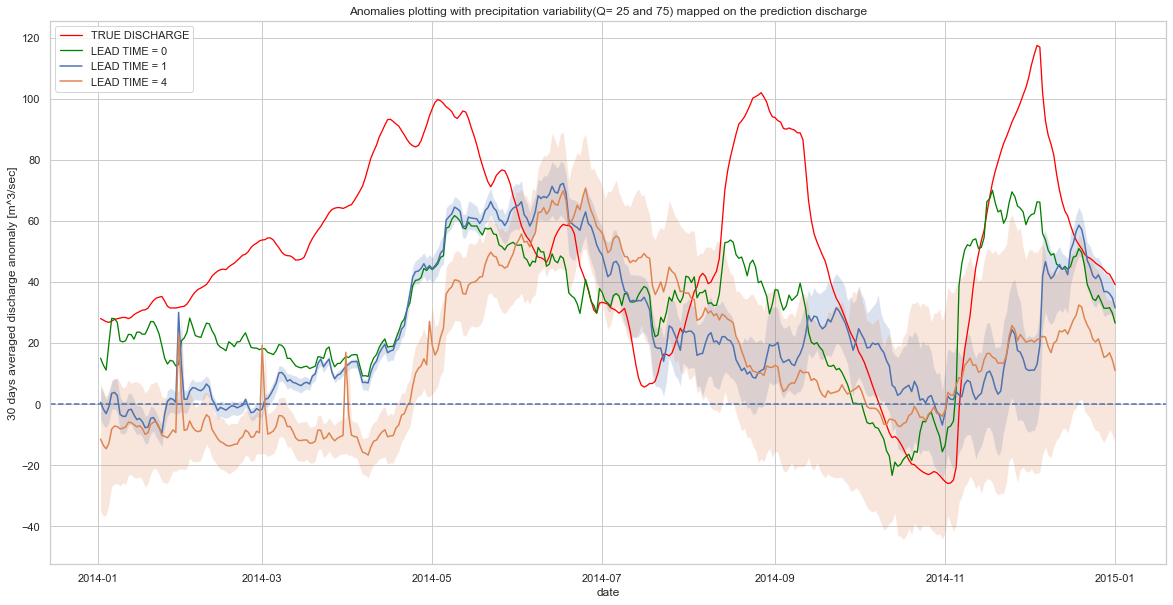

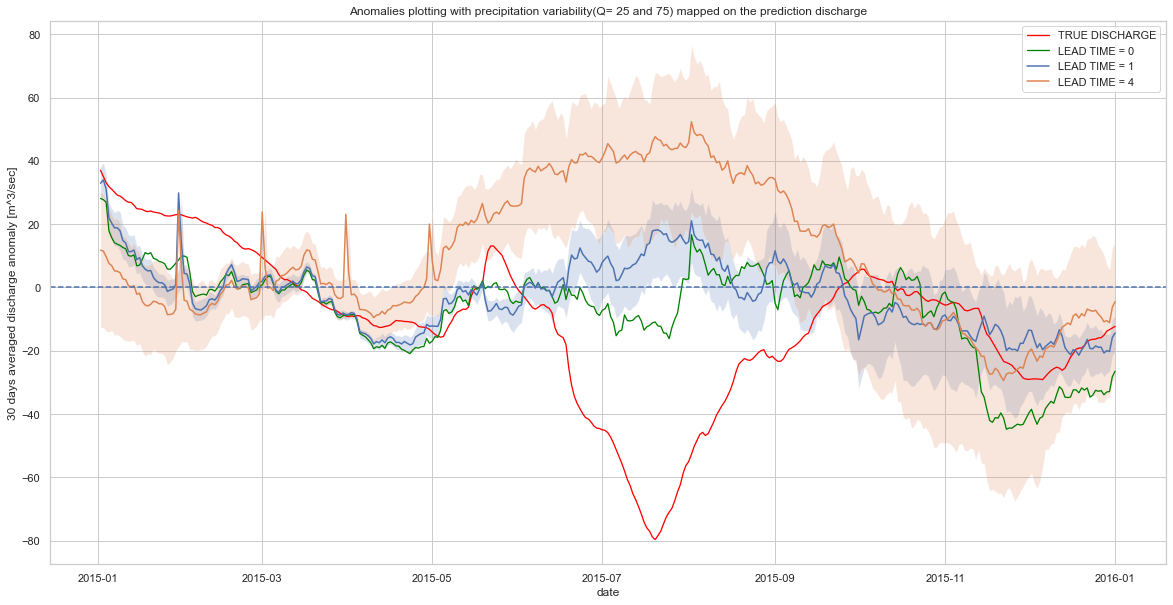

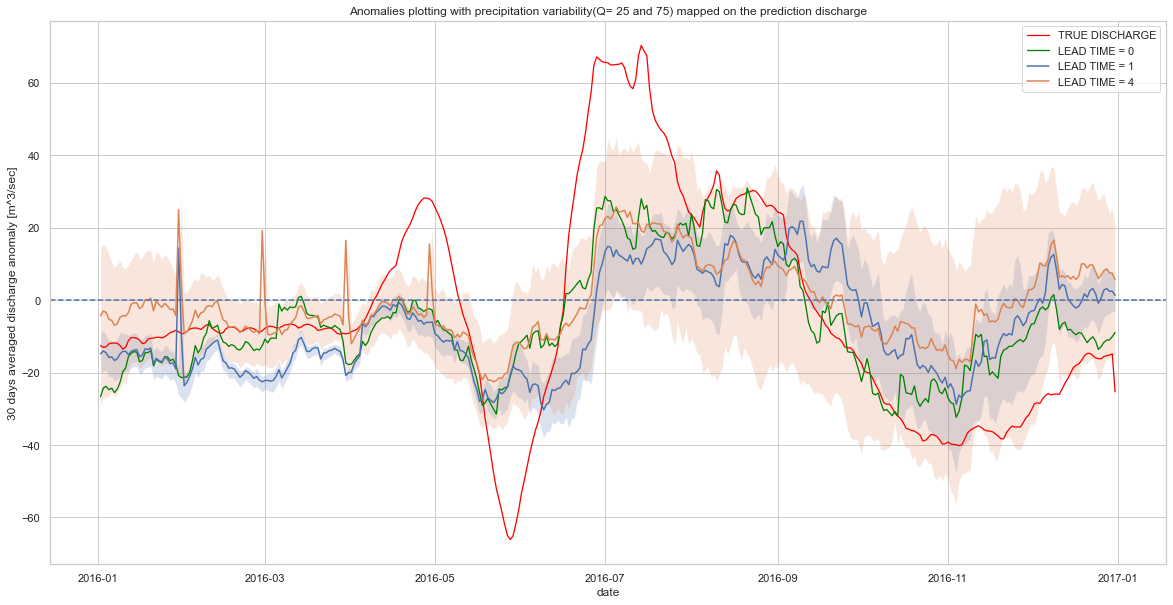

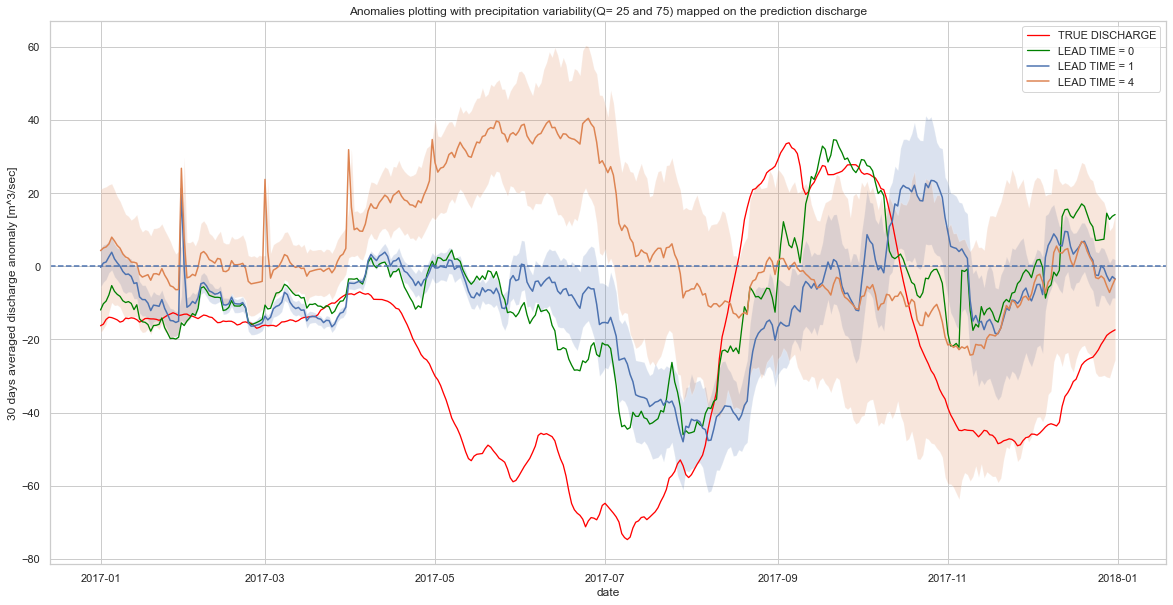

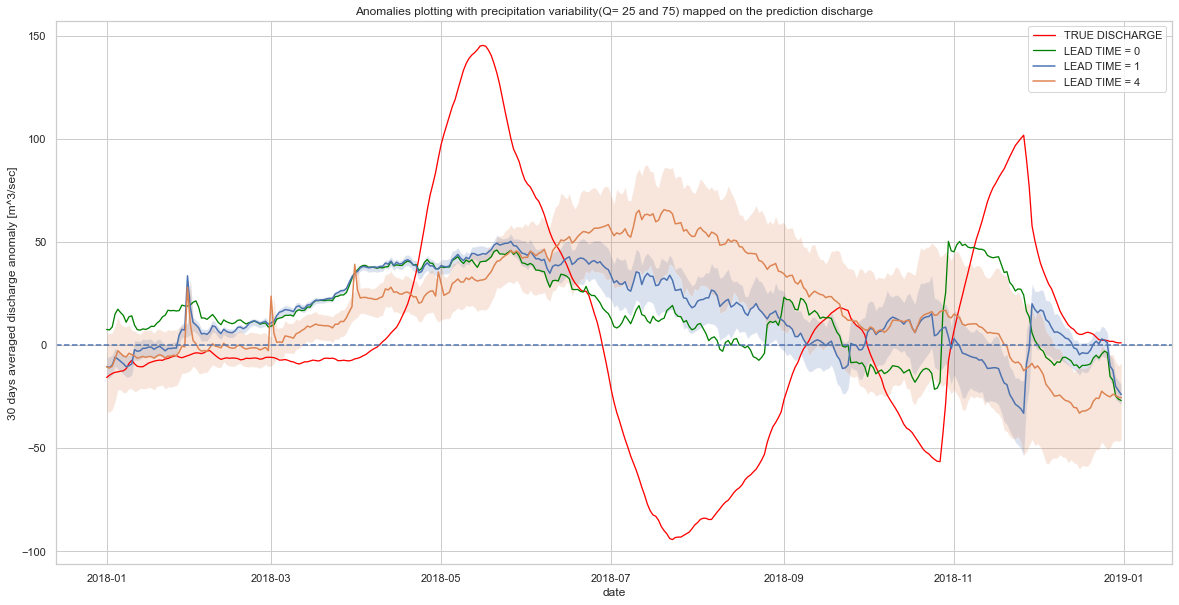

In [31]:
a3=compute_anomalies(climatologies3, predictions3)
a3['split']=predictions3.split

plot_anomalies(a3)

# COMPARE RESULTS

Text(0, 0.5, 'r^2 [/]')

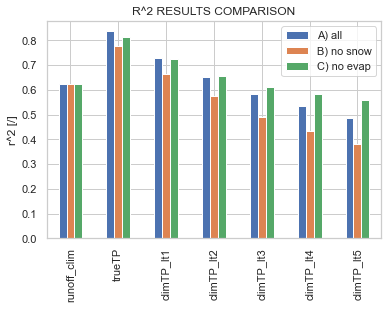

In [36]:
results = pd.concat([r2_A,r2_B,r2_C],axis=1)
results.columns=['A) all','B) no snow','C) no evap']
results.iloc[1:].plot.bar()
plt.title('R^2 RESULTS COMPARISON')
plt.ylabel('r^2 [/]')

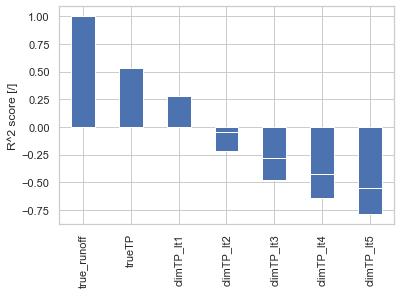

In [33]:
r2_a_C= evaluate_prediction(a3)
r2_a_B = evaluate_prediction(a2)
r2_a_A = evaluate_prediction(a)

Text(0.5, 1.0, 'R^2 RESULTS COMPARISON')

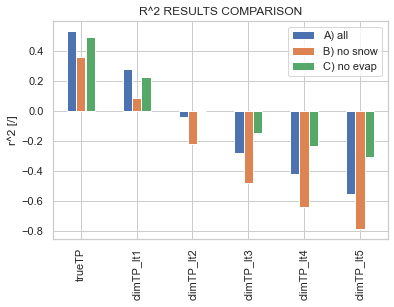

In [50]:
results_a = pd.concat([r2_a_A,r2_a_B,r2_a_C],axis=1)
results_a.columns=['A) all','B) no snow','C) no evap']
results_a.iloc[1:].plot.bar()
plt.ylabel('r^2 [/]')
plt.title('R^2 RESULTS COMPARISON')

In [47]:
arrays[0][1].shape

(8,)

In [48]:
arrays = [[np.array(np.repeat((t_unit),8),dtype=object),np.array(results.index)]]
tup=np.concatenate(arrays)
index = pd.MultiIndex.from_arrays(tup, names=["t_unit" , "lt"])

results.index=index

results


A) all  B) no snow  C) no evap
t_unit lt                                           
30     true_runoff  1.000000    1.000000    1.000000
       runoff_clim  0.624577    0.624577    0.624577
       trueTP       0.837046    0.776085    0.812261
       climTP_lt1   0.728135    0.662102    0.724833
       climTP_lt2   0.651458    0.575916    0.656473
       climTP_lt3   0.581264    0.491243    0.610694
       climTP_lt4   0.536651    0.433303    0.583789
       climTP_lt5   0.485000    0.380214    0.559508

In [51]:
arrays = [[np.array(np.repeat((t_unit),7),dtype=object),np.array(results_a.index)]]
tup=np.concatenate(arrays)
index = pd.MultiIndex.from_arrays(tup, names=["t_unit" , "lt"])

results_a.index=index

results_a

A) all  B) no snow  C) no evap
t_unit lt                                           
30     true_runoff  1.000000    1.000000    1.000000
       trueTP       0.531529    0.357429    0.490661
       climTP_lt1   0.277010    0.082154    0.221240
       climTP_lt2  -0.043430   -0.219444    0.000898
       climTP_lt3  -0.282149   -0.483476   -0.152207
       climTP_lt4  -0.424239   -0.644645   -0.237997
       climTP_lt5  -0.553686   -0.787544   -0.307520

In [52]:
results.to_csv('results/BRONZOLO__30.csv')
results_a.to_csv('results/BRONZOLO__30_a.csv')

In [4]:
results_a = pd.read_csv('results/BRONZOLO__30_a.csv')

In [10]:
results_a.index=results_a.iloc[:,1]

Text(0.5, 1.0, 'R^2 RESULTS COMPARISON')

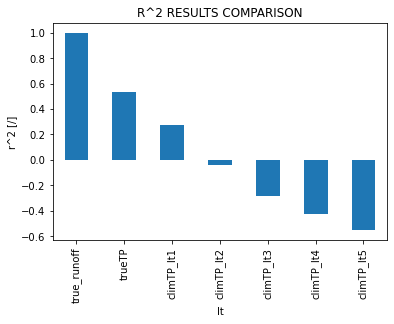

In [13]:
results_a['A) all'].plot.bar()
plt.ylabel('r^2 [/]')
plt.title('R^2 RESULTS COMPARISON')